# Turkish sentiment from scratch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.greedy=True


from fastai import *
from fastai.text import *
from nlputils import split_wiki,get_wiki

In [31]:
bs=256
torch.cuda.set_device(3)
data_path = Config.data_path()

lang = 'tr'
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)

In [32]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
lm_fns = [mdl_path/f'{lang}_wt', mdl_path/f'{lang}_wt_vocab']

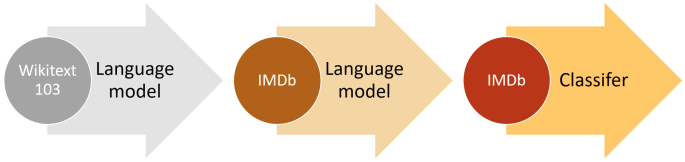

## Turkish wikipedia model

In [4]:
get_wiki(path,lang)
!head -n4 {path}/{name}

downloading...


unzipping...
extracting...
<doc id="10" url="https://tr.wikipedia.org/wiki?curid=10" title="Cengiz Han">
Cengiz Han

Cengiz Han ("Cenghis Khan", "Çinggis Haan" ya da doğum adıyla Temuçin (anlamı: demirci), Moğolca: "Чингис Хаан" ya da "Tengiz" (anlamı: deniz), ; d. 1162 – ö. 18 Ağustos 1227), Moğol komutan, hükümdar ve Moğol İmparatorluğu'nun kurucusudur. Cengiz Han, 13. Yüzyılın başında Orta Asya'daki tüm göçebe bozkır kavimlerini birleştirerek bir ulus haline getirdi ve o ulusu "Moğol" siyasi kimliği çatısı altında topladı. Dünya tarihinin en büyük askeri dehalarından biri olarak kabul edilen Cengiz Han, hükümdarlığı döneminde 1206-1227 arasında Kuzey Çin'deki Batı Xia ve Jin Hanedanı, Türkistan'daki Kara Hıtay, Maveraünnehir, Harezm, Horasan ve İran'daki Harzemşahlar ile Kafkasya'da Gürcüler, Deşt-i Kıpçak'taki Rus Knezlikleri ve Kıpçaklar ile İdil Bulgarları üzerine gerçekleştirilen seferler sonucunda Pasifik Okyanusu'ndan Hazar Denizi’ne ve Karadeniz'in kuzeyine kadar uzanan bir i

In [5]:
dest = split_wiki(path,lang)

/home/ismail.yildirim/.fastai/data/trwiki/docs already exists; not splitting


Turkish is an [Agglutinative_language](https://en.wikipedia.org/wiki/Agglutinative_language) so it needs special care!

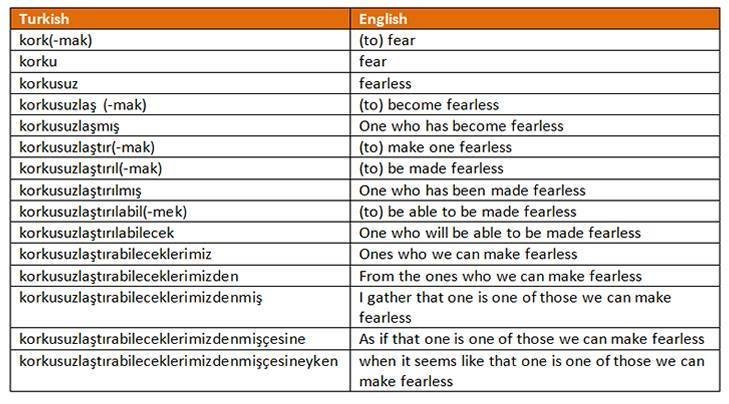

In [7]:
data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), SPProcessor()])
        .split_by_rand_pct(0.1, seed=42)
        .label_for_lm()
        .databunch(bs=bs, num_workers=1))

data.save(f'{lang}_databunch')
len(data.vocab.itos),len(data.train_ds)

(30000, 45800)

In [5]:
data = load_data(dest, f'{lang}_databunch', bs=bs)

In [6]:
data.show_batch()

idx,text
0,"▁karayip ▁gelenekleri nin ▁bir ▁sentezi ▁olarak ▁kendini ▁gösterir . ▁xxmaj ▁genelde ▁zengin ▁bitki ▁örtüsü ne ▁sahip ▁olan ▁bu ▁sıcak , ▁top ik ▁ülkenin ▁mutfağında ▁mısır , ▁fasulye , ▁meyve ▁çeşitleri ▁ve ▁belirli ▁sebze ▁türleri ▁önemli ▁bir ▁rol ▁oynar . ▁xxmaj ▁meksika ' da ▁birbirinden ▁çok ▁farklı ▁bölgesel ▁mutfak lar ▁mevcuttur . ▁xxmaj ▁kuzeyde ▁xxmaj ▁i ̇ spanyol ▁mutfağı nın ▁etkisi ▁görülür ken , ▁güneyde ▁yerli lerin ▁mutfağı ▁korunmuştur . ▁xxmaj"
1,"▁xxmaj ▁müzik ▁xxmaj ▁ödülleri ' nde ▁açıklandı . ▁xxmaj ▁i ̇ ki ▁gün ▁sonra ▁ilk ▁single ▁"" ber zer k "", ▁xxmaj ▁amerika ▁xxmaj ▁birleşik ▁xxmaj ▁devletleri ' nde ▁piyasaya ▁çıktı . ▁xxmaj ▁şarkı ▁"" billboard "" ▁xxmaj ▁hot ▁100 ▁listesinde ▁üç ▁numaraya ▁yükseldi . ▁xxmaj ▁onu ▁xxmaj ▁ekim ▁ayında ▁çıkan ▁"" sur vi val "" ▁ve ▁"" rap ▁xxmaj ▁god "" ▁izledi . ▁"" sur vi val "" ▁xxmaj"
2,"▁ve ▁xxmaj ▁ bach ▁gibi ▁müzisyenler in ▁beste lir ine ▁rast ladı . ▁1996 ▁yılında ▁ailesiyle ▁xxmaj ▁londra ' ya ▁taşındı . ▁15 ▁yaşında , ▁xxmaj ▁büyük ▁xxmaj ▁britanya ▁xxmaj ▁giriş ▁ve ▁xxmaj ▁i ̇ ş ▁verme ▁seviyesinde ▁xxmaj ▁müzik ▁xxmaj ▁üretim ▁ve ▁xxmaj ▁i ̇ şletme ▁xxmaj ▁kursu na ▁katıldı ; ▁16 ▁yaşında ' da ▁mezun ▁oldu . ▁xxmaj ▁daha ▁sonra , ▁müzik ▁kariyerine ▁devam ▁etmek ▁için ▁xxmaj ▁kol"
3,"▁birçok ▁lehçe ▁konuşulur . ▁xxmaj ▁fakat ▁bu ▁diller ▁kuzey in ▁xxmaj ▁arapça ' sından ▁o ▁kadar ▁farklıdır ▁ki ▁güney ▁xxmaj ▁arapça ▁çoğu ▁zaman ▁ayrı ▁bir ▁dil ▁olarak ▁kabul ▁edilir . ▁xxmaj ▁modern ▁xxmaj ▁arapça ; ▁temel ▁sözcükler , ▁ morfoloji ▁ve ▁söz dizi mi ▁bütünü ▁bakımından ▁xxmaj ▁kur ' an ' daki ▁gibidir . ▁xxmaj ▁günümüzde ▁yaygın ▁olan ▁pek ▁çok ▁dil ▁xxmaj ▁arapça nın ▁zengin ▁söz ▁varlığından ▁pek ▁çok ▁sözcük"
4,"▁xxmaj ▁mercedes ▁ gp ' nin ▁ilk ▁podyum unu ▁xxmaj ▁malezya ' da ▁3. ▁sırada ▁tamamlayarak ▁kazandı . ▁xxmaj ▁takım , ▁ilk ▁galibiyetini ▁15 ▁xxmaj ▁nisan ▁2012' de ▁xxmaj ▁çin ▁yarışında ▁xxmaj ▁ nico ▁xxmaj ▁ ros berg ▁ile ▁kazandı . ▁xxmaj ▁takım ▁başarısını ▁xxmaj ▁schumacher ' in ▁xxmaj ▁monako ' da ▁pol ▁pozisyonunu ▁alması , ▁xxmaj ▁ ros berg ' in ▁ise ▁yarış ▁sonunda ▁podyum a ▁çıkması ▁ile ▁sürdürdü"


In [7]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.1, wd=0.1, pretrained=False).to_fp16()

In [8]:
lr = 3e-3
lr *= bs/48  # Scale learning rate by batch size

In [9]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.251970,4.419552,0.299080,31:21
1,4.218757,4.416518,0.297524,31:17
2,4.186292,4.467695,0.294030,31:25
3,4.171142,4.400369,0.299168,31:29
4,4.077125,4.300411,0.306440,31:26
5,3.955276,4.169568,0.318361,31:54
6,3.863966,4.007720,0.332388,32:02
7,3.696660,3.819888,0.350384,31:59
8,3.551979,3.644711,0.369559,32:01
9,3.437696,3.583472,0.377601,32:01


In [10]:
learn.to_fp32().save(lm_fns[0], with_opt=False)
learn.data.vocab.save(lm_fns[1].with_suffix('.pkl'))

## Turkish sentiment analysis

https://www.win.tue.nl/~mpechen/projects/smm/

### Language model

In [7]:
path_clas = path/'movies'
path_clas.ls()

[PosixPath('/home/ismail.yildirim/.fastai/data/trwiki/movies/models'),
 PosixPath('/home/ismail.yildirim/.fastai/data/trwiki/movies/tr_polarity.pos'),
 PosixPath('/home/ismail.yildirim/.fastai/data/trwiki/movies/tr_polarity.neg'),
 PosixPath('/home/ismail.yildirim/.fastai/data/trwiki/movies/tr_clas_databunch'),
 PosixPath('/home/ismail.yildirim/.fastai/data/trwiki/movies/tr_clas_128b_databunch')]

In [8]:
pos = (path_clas/'tr_polarity.pos').open(encoding='iso-8859-9').readlines()
pos_df = pd.DataFrame({'text':pos})
pos_df['pos'] = 1
pos_df.head()

,text,pos
0,gerçekten harika bir yapim birçok kez izledim ...,1
1,her izledigimde hayranlik duydugum gerçek klas...,1
2,gerçekten tarihi savas filmleri arasinda tarti...,1
3,aldigi ödülleri sonuna dek hak eden muhtesem b...,1
4,özgürlük denilince aklima gelen ilk film.bir b...,1


In [9]:
neg = (path_clas/'tr_polarity.neg').open(encoding='iso-8859-9').readlines()
neg_df = pd.DataFrame({'text':neg})
neg_df['pos'] = 0
neg_df.head()

,text,pos
0,giseye oynayan bir film.mel gibson'in oyunculu...,0
1,bircok yonden sahip olduklari zayifliklari pop...,0
2,"1995 ten bu yana bu tür filmler artti , o zama...",0
3,mel gibson tam bir ingiliz düsmani her filmind...,0
4,milliyetçi bir film tavsiye etmiyorum.... \n,0


In [10]:
df = pd.concat([pos_df,neg_df], sort=False)

In [15]:
data_lm = (TextList.from_df(df, path_clas, cols='text', processor=SPProcessor.load(dest))
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

data_lm.save(f'{lang}_clas_databunch')

In [16]:
data_lm = load_data(path_clas, f'{lang}_clas_databunch', bs=bs)

In [17]:
data_lm.show_batch()

idx,text
0,"sa ▁bile ▁sinema ▁olgusu nun ▁en ▁üst ▁noktalar in dan . . ▁xxbos ▁gerçekten ▁tarihi ▁sava s ▁filmleri ▁ara si nda ▁tar tis ma siz ▁en ▁iyi si ▁ , ▁12 ▁ yi l ▁boyunca ▁ a caba ▁ikincisi ▁çek ir imi ▁diye ▁bekledi gi m ▁bir ▁film ▁ , bel ki ▁william ▁wallace ▁baba sinin ▁ölümünden ▁sonra ▁amca si ▁yani na ▁al mis ti ▁onu ▁ ye tis tir"
1,▁bir ▁film . ▁ . ▁xxbos ▁bir ▁insan ▁bu ▁filmi ▁izleme den ▁ölme meli ! !! . ▁xxbos ▁diye cek ▁bi ▁sey ▁bu la mi yorum ▁bu ▁film ▁hak ki nda ▁kelimeler ▁yetme z ▁mükemmel in ▁kat ▁kat ▁ötesi ▁xxrep ▁4 ▁ . ▁xxbos ▁dünyaya ▁gel mis ▁geç mis ▁en ▁güzel ▁filmlerden ▁biri ▁ben ce . . bir ▁bas ya pit ▁bir ▁unutulmaz ▁film ▁kelime er ▁yetme z ▁anlatmaya ▁xxrep
2,▁konusu yla ▁is le ni siyle ▁insana ▁ iste ▁film ▁böyle ▁çekilir ▁de dir ten ▁kusur suz ▁bir ▁film . ▁xxbos ▁böyle ▁güzel ▁bir ▁ya pit ▁olamaz ▁filmde ▁her ▁sey ▁var ▁insani ▁dünya dan ▁ali p ▁gö türü yor ▁bask a ▁diyar lara ▁film ▁bitti kten ▁sonra ▁epey ▁süre ▁geçmesi ▁gerekiyor ▁tekrar ▁dünya ▁ya ▁dönmek ▁için ▁dikkat ! . ▁xxbos ▁inan ir mi siniz ▁bu ▁filmi ▁ ne ▁kadar ▁izledi
3,"▁film ▁kesinlikle ▁izlenme li . ▁xxbos ▁hayat im da ▁izledi gi m ▁en ▁iyi ▁film ▁ve ▁bundan ▁iyi sini ▁de ▁yap amayacak lar , mel ▁gibson ▁bask a ▁söz e ▁gerek ▁yok ▁gördü gü m ▁en ▁iyi ▁oyuncu . ▁ . ▁xxbos ▁iz lenebilecek ▁en ▁güzel ▁filmlerden ▁birisi . ▁xxrep ▁4 ▁ a ▁ h ▁özgürlük . . ▁xxbos ▁bas ya pit lara ▁söylene cek ▁söz ▁yoktur ; ▁bazen ▁"
4,ug ru na ▁sava san ▁william ▁wallace  in ▁i sk ence ▁edilerek ▁idam ▁edilmesi . . . ve ▁sonunda ▁özgürlük ▁diye ▁hay kir isi . . . ha lan ▁unut ami yorum ▁xxrep ▁4 ▁ . ▁xxbos ▁ilk ▁bu ▁filmi ▁sinema da ▁izledi m ▁ve ▁insan in ▁inan di ktan ▁sonra ▁ ne leri ▁yap a bile ce gi ni ▁fark ▁etti m . ▁gerçekten ▁süper ▁film di .


In [18]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0, wd=0.1)

In [19]:
lr = 1e-3
lr *= bs/48

In [20]:
learn_lm.fit_one_cycle(1, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.949381,4.186094,0.304408,00:11


In [21]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(5, slice(lr/10,lr*10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.185816,3.998840,0.324851,00:13
1,4.043659,3.910633,0.338821,00:13
2,3.857762,3.849993,0.346224,00:13
3,3.660223,3.822170,0.356380,00:13
4,3.457944,3.840013,0.358631,00:13


In [22]:
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

### Classifier

In [11]:
data_clas = (TextList.from_df(df, path_clas, cols='text', processor=SPProcessor.load(dest))
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='pos')
    .databunch(bs=bs, num_workers=1))

In [24]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, pretrained=False, wd=0.1).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc')
learn_c.freeze()

In [25]:
lr=2e-2
lr *= bs/48

In [26]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.465303,0.570707,0.678236,00:04
1,0.443859,0.451629,0.778612,00:04


In [27]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.465638,0.467127,0.792683,00:04
1,0.443376,0.416440,0.805816,00:04


In [28]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.387554,0.342689,0.848030,00:05
1,0.302855,0.281516,0.889306,00:05


In [29]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.259074,0.289010,0.893058,00:07
1,0.202927,0.268644,0.900563,00:07


In [30]:
learn_c.unfreeze()
learn_c.fit_one_cycle(4, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.125211,0.255720,0.916510,00:10
1,0.104033,0.333733,0.891182,00:10
2,0.075831,0.370521,0.902439,00:09
3,0.053192,0.366858,0.901501,00:09


In [31]:
learn_c.save(f'{lang}clas')

In [ ]:
learn_c.export(f'{lang}clas_export')